# Multi-Class Image Classification Deep Learning Model for [PROJECT NAME] Using TensorFlow Version 2
### David Lowe
### January 5, 2022

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using a TensorFlow convolutional neural network (CNN) and document the end-to-end steps using a template. The [PROJECT NAME] dataset is a multi-class classification situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: [Sample Paragraph - The Rock Paper Scissors dataset contains images from a variety of different hand poses with different races, ages, and genders. These images have all been generated using CGI techniques as an experiment in determining if a CGI-based dataset can be used for classification against real photos. All of this data is posed against a white background, and each image is 300×300 pixels in 24-bit color.]

ANALYSIS: [Sample Paragraph - The performance of the baseline model achieved an accuracy score of 75.40% after 10 epochs using the training dataset. After tuning the hyperparameters, the best model processed the validation dataset with an accuracy score of 100%. Furthermore, the final model processed the test dataset with an accuracy measurement of 83.33%.]

CONCLUSION: In this iteration, the TensorFlow CNN model appeared to be suitable for modeling this dataset. We should consider experimenting with TensorFlow for further modeling.

Dataset Used: [PROJECT NAME] Dataset

Dataset ML Model: Multi-class image classification with numerical attributes

Dataset Reference: [http://www.laurencemoroney.com/rock-paper-scissors-dataset/]

One potential source of performance benchmarks: [http://www.laurencemoroney.com/rock-paper-scissors-dataset/]

# Task 1 - Prepare Environment

In [1]:
# # Install the packages to support accessing environment variable and SQL databases
# !pip install python-dotenv PyMySQL boto3

In [2]:
# # Retrieve GPU configuration information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# # Retrieve memory configuration information from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# # Mount Google Drive locally for loading the dotenv files
# from dotenv import load_dotenv
# from google.colab import drive
# drive.mount('/content/gdrive')
# gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
# env_path = '/content/gdrive/My Drive/Colab Notebooks/'
# dotenv_path = env_path + "python_script.env"
# load_dotenv(dotenv_path=dotenv_path)

In [5]:
# Retrieve CPU information from the system
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


## 1.a) Load libraries and modules

In [6]:
# Set the random seed number for reproducible results
RNG_SEED = 88

In [7]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import math
# import boto3
import zipfile
from datetime import datetime
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
tf.random.set_seed(RNG_SEED)
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1.b) Set up the controlling parameters and functions

In [8]:
# Begin the timer for the script processing
START_TIME_SCRIPT = datetime.now()

In [9]:
# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_LOSS = 'categorical_crossentropy'
DEFAULT_METRICS = ['accuracy']
DEFAULT_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)
DEFAULT_INITIALIZER = tf.keras.initializers.RandomNormal(seed=RNG_SEED)
CLASSIFIER_ACTIVATION = 'softmax'
MAX_EPOCHS = 10
BATCH_SIZE = 16
NUM_CLASSES = 3
CLASS_LABELS = ['rock','paper','scissors']
# CLASS_NAMES = []
# RAW_IMAGE_SIZE = (1280, 720)
TARGET_IMAGE_SIZE = (299, 299)
INPUT_IMAGE_SHAPE = (TARGET_IMAGE_SIZE[0], TARGET_IMAGE_SIZE[1], 3)

# Define the labels to use for graphing the data
TRAIN_METRIC = "accuracy"
VALIDATION_METRIC = "val_accuracy"
TRAIN_LOSS = "loss"
VALIDATION_LOSS = "val_loss"

# Define the directory locations and file names
STAGING_DIR = 'staging/'
TRAIN_DIR = 'staging/training/'
# VALID_DIR = ''
TEST_DIR = 'staging/test/'
TRAIN_DATASET = 'rps.zip'
# VALID_DATASET = ''
TEST_DATASET = 'rps-test-set.zip'
# TRAIN_LABELS = ''
# VALID_LABELS = ''
# TEST_LABELS = ''
# OUTPUT_DIR = 'staging/'
# SAMPLE_SUBMISSION_CSV = 'sample_submission.csv'
# FINAL_SUBMISSION_CSV = 'submission.csv'

# Check the number of GPUs accessible through TensorFlow
print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

Num GPUs Available: 1
TensorFlow version: 2.6.0


2022-01-04 17:46:27.467493: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 17:46:27.631408: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 17:46:27.632568: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [10]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [11]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [12]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [13]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 1 - Prepare Environment completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 2 - Load and Prepare Images

In [14]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [15]:
# Clean up the old files and download directories before receiving new ones
!rm -rf staging/
!rm rps.zip
!rm rps-test-set.zip
!mkdir staging/

In [16]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps.zip

--2022-01-04 17:46:33--  https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 13.32.151.78, 13.32.151.98, 13.32.151.38, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|13.32.151.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘rps.zip’

rps.zip             100%[===================>] 191.38M  22.8MB/s    in 8.5s    

2022-01-04 17:46:41 (22.4 MB/s) - ‘rps.zip’ saved [200682221/200682221]



In [17]:
zip_ref = zipfile.ZipFile(TRAIN_DATASET, 'r')
zip_ref.extractall(TRAIN_DIR)
zip_ref.close()

In [18]:
# Making the adjustment to the training directory name after zip file extraction
TRAIN_DIR = TRAIN_DIR + 'rps/'

In [19]:
# Brief listing of training image files for each class
for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    print('Number of training images for', c_label, ':', len(os.listdir(training_class_dir)))
    print('Training samples for', c_label, ':')
    print(training_class_files[:5],'\n')

Number of training images for rock : 840
Training samples for rock :
['rock03-039.png', 'rock04-116.png', 'rock01-112.png', 'rock05ck01-036.png', 'rock06ck02-106.png'] 

Number of training images for paper : 840
Training samples for paper :
['paper02-040.png', 'paper03-049.png', 'paper07-075.png', 'paper07-086.png', 'paper04-032.png'] 

Number of training images for scissors : 840
Training samples for scissors :
['scissors01-036.png', 'scissors02-070.png', 'scissors04-020.png', 'scissors02-067.png', 'scissors02-056.png'] 



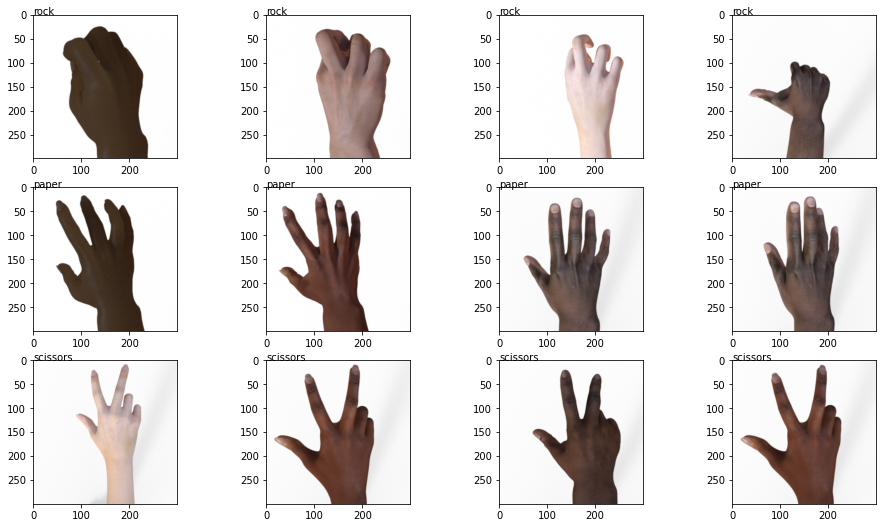

In [20]:
# Plot some training images from the dataset
nrows = 3
ncols = 4
training_examples = []
example_labels = []

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 3)

for c_label in CLASS_LABELS:
    training_class_dir = os.path.join(TRAIN_DIR, c_label)
    training_class_files = os.listdir(training_class_dir)
    for j in range(ncols):
        training_examples.append(training_class_dir + '/' + training_class_files[j])
        example_labels.append(c_label)
    # print(training_examples)
    # print(example_labels)

for i, img_path in enumerate(training_examples):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i+1)
    sp.text(0, 0, example_labels[i])
    # sp.axis('Off')
    img = mpimg.imread(img_path)
    plt.imshow(img)
plt.show()

In [21]:
datagen_kwargs = dict(rescale=1./255, validation_split=VAL_SET_RATIO)
training_datagen = ImageDataGenerator(**datagen_kwargs)
validation_datagen = ImageDataGenerator(**datagen_kwargs)
dataflow_kwargs = dict(class_mode="categorical")

do_data_augmentation = True
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=90,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          subset="training",
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

print('Loading and pre-processing the validation images...')
validation_generator = validation_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                              target_size=TARGET_IMAGE_SIZE,
                                                              batch_size=BATCH_SIZE,
                                                              shuffle=False,
                                                              subset="validation",
                                                              **dataflow_kwargs)
print('Number of validation image batches per epoch of modeling:', len(validation_generator))

Loading and pre-processing the training images...
Found 2016 images belonging to 3 classes.
Number of training image batches per epoch of modeling: 126
Loading and pre-processing the validation images...
Found 504 images belonging to 3 classes.
Number of validation image batches per epoch of modeling: 32


In [22]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 2 - Load and Prepare Images completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 3 - Define and Train Models

In [23]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [24]:
# Define the function for plotting training results for comparison
def plot_metrics(history):
    fig, axs = plt.subplots(1, 2, figsize=(24, 15))
    metrics =  [TRAIN_LOSS, TRAIN_METRIC]
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color='blue', label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color='red', linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == TRAIN_LOSS:
            plt.ylim([0, plt.ylim()[1]])
        else:
            plt.ylim([0.5, 1.1])
        plt.legend()

In [25]:
# Define the baseline model for benchmarking
def create_nn_model(input_param=INPUT_IMAGE_SHAPE, output_param=NUM_CLASSES, dense_nodes=1024,
                    init_param=DEFAULT_INITIALIZER, classifier_activation=CLASSIFIER_ACTIVATION,
                    loss_param=DEFAULT_LOSS, opt_param=DEFAULT_OPTIMIZER, metrics_param=DEFAULT_METRICS):
    base_model = keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet', input_shape=input_param)
    nn_model = keras.models.Sequential()
    nn_model.add(base_model)
    nn_model.add(keras.layers.Flatten())
    nn_model.add(keras.layers.Dense(dense_nodes, activation='relu', kernel_initializer=init_param)),
    nn_model.add(keras.layers.Dense(output_param, activation=classifier_activation, kernel_initializer=init_param))
    nn_model.compile(loss=loss_param, optimizer=opt_param, metrics=metrics_param)
    return nn_model

In [26]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
tf.keras.backend.clear_session()
reset_random()
baseline_model = create_nn_model()
baseline_model_history = baseline_model.fit(training_generator,
                                            epochs=MAX_EPOCHS,
                                            validation_data=validation_generator,
                                            verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

2022-01-04 17:46:45.708943: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 17:46:45.710165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 17:46:45.711279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 17:46:49.170414: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-04 17:46:49.171374: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1050] successful NUMA node read f

87924736/87910968 [==============================] - 4s 0us/step


2022-01-04 17:46:56.350692: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-01-04 17:47:05.182493: I tensorflow/stream_executor/cuda/cuda_dnn.cc:381] Loaded cuDNN version 8204


126/126 [==============================] - 61s 369ms/step - loss: 8.4741 - accuracy: 0.3849 - val_loss: 1110.8861 - val_accuracy: 0.2917
Epoch 2/10
126/126 [==============================] - 43s 339ms/step - loss: 1.1002 - accuracy: 0.5278 - val_loss: 0.7743 - val_accuracy: 0.6329
Epoch 3/10
126/126 [==============================] - 44s 344ms/step - loss: 0.5471 - accuracy: 0.7842 - val_loss: 1.1281 - val_accuracy: 0.6667
Epoch 4/10
126/126 [==============================] - 45s 357ms/step - loss: 0.2720 - accuracy: 0.9033 - val_loss: 0.2957 - val_accuracy: 0.9325
Epoch 5/10
126/126 [==============================] - 45s 357ms/step - loss: 0.1741 - accuracy: 0.9420 - val_loss: 0.1602 - val_accuracy: 0.9444
Epoch 6/10
126/126 [==============================] - 42s 334ms/step - loss: 0.1448 - accuracy: 0.9603 - val_loss: 0.2089 - val_accuracy: 0.9246
Epoch 7/10
126/126 [==============================] - 43s 342ms/step - loss: 0.1395 - accuracy: 0.9593 - val_loss: 0.2685 - val_accuracy: 

In [27]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 156,024,611
Trainable params: 155,990,179
Non-trainable params: 34,432
_________________________________________________________________


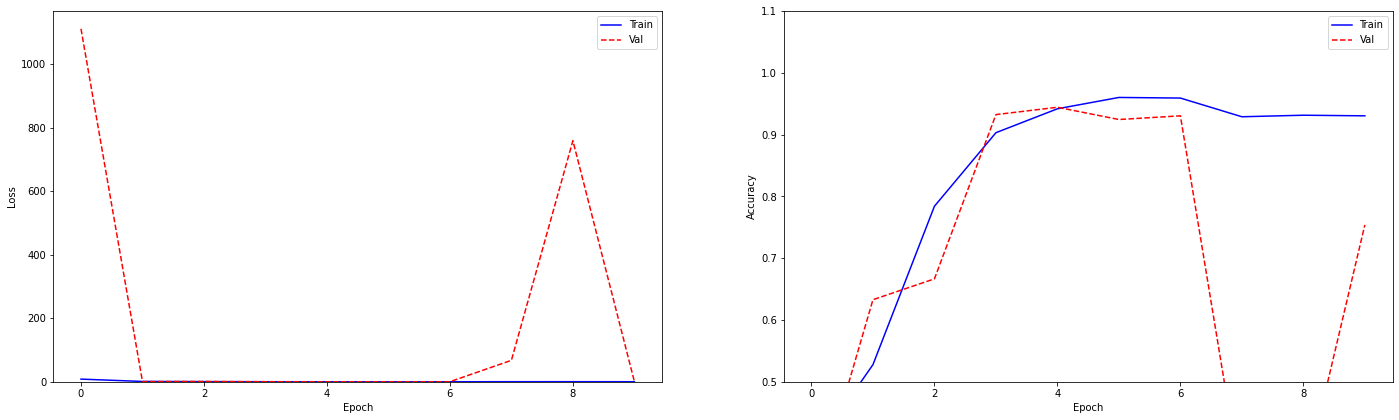

In [28]:
plot_metrics(baseline_model_history)

In [29]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 3 - Define and Train Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 4 - Tune and Optimize Models

In [30]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [31]:
# Initialize the neural network model and get the training results for plotting graph
start_time_module = datetime.now()
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.000001)
TUNE_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.0005)
tf.keras.backend.clear_session()
reset_random()
tune_model = create_nn_model(opt_param=TUNE_OPTIMIZER)
tune_model_history = tune_model.fit(training_generator,
                                    epochs=MAX_EPOCHS,
                                    validation_data=validation_generator,
                                    callbacks=[learning_rate_reduction],
                                    verbose=1)
print('Total time for model fitting:', (datetime.now() - start_time_module))

Epoch 1/10
126/126 [==============================] - 51s 357ms/step - loss: 6.8562 - accuracy: 0.8209 - val_loss: 1.4784 - val_accuracy: 0.4722
Epoch 2/10
126/126 [==============================] - 44s 346ms/step - loss: 0.1020 - accuracy: 0.9702 - val_loss: 0.0568 - val_accuracy: 0.9742
Epoch 3/10
126/126 [==============================] - 43s 337ms/step - loss: 0.1813 - accuracy: 0.9737 - val_loss: 0.0126 - val_accuracy: 0.9980
Epoch 4/10
126/126 [==============================] - 44s 346ms/step - loss: 0.0907 - accuracy: 0.9732 - val_loss: 0.0568 - val_accuracy: 0.9881
Epoch 5/10
126/126 [==============================] - 44s 348ms/step - loss: 0.0200 - accuracy: 0.9960 - val_loss: 0.1863 - val_accuracy: 0.9544
Epoch 6/10
126/126 [==============================] - 43s 342ms/step - loss: 0.0107 - accuracy: 0.9965 - val_loss: 0.0132 - val_accuracy: 0.9960

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 7/10
126/126 [=============================

In [32]:
tune_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 156,024,611
Trainable params: 155,990,179
Non-trainable params: 34,432
_________________________________________________________________


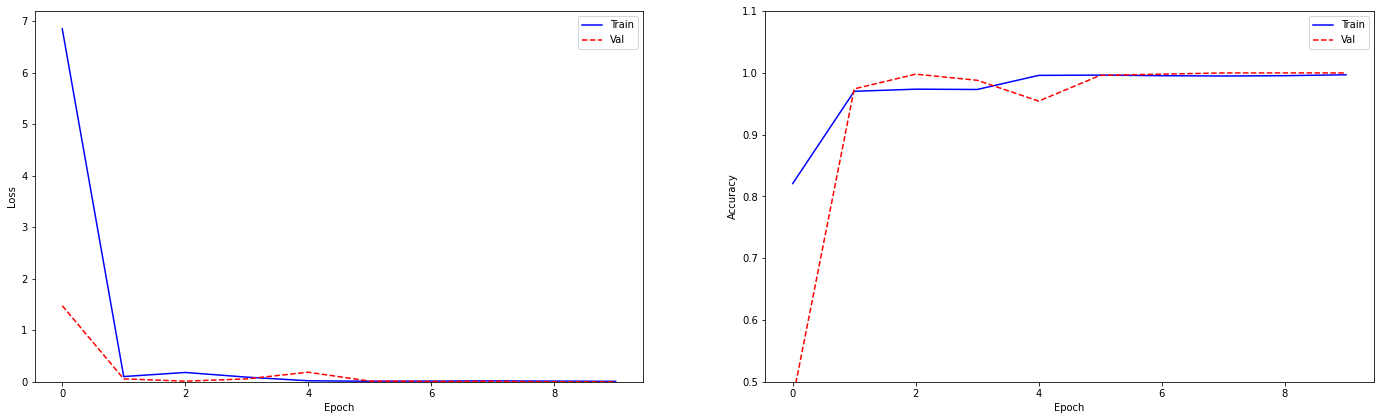

In [33]:
plot_metrics(tune_model_history)

In [34]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 4 - Tune and Optimize Models completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

# Task 5 - Finalize Model and Make Predictions

In [35]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions has begun on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [36]:
# Train the model with the entire training set
datagen_kwargs = dict(rescale=1./255)
training_datagen = ImageDataGenerator(**datagen_kwargs)

do_data_augmentation = True
if do_data_augmentation:
    training_datagen = ImageDataGenerator(rotation_range=90,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          **datagen_kwargs)

print('Loading and pre-processing the training images...')
training_generator = training_datagen.flow_from_directory(directory=TRAIN_DIR,
                                                          target_size=TARGET_IMAGE_SIZE,
                                                          batch_size=BATCH_SIZE,
                                                          shuffle=True,
                                                          seed=RNG_SEED,
                                                          **dataflow_kwargs)
print('Number of training image batches per epoch of modeling:', len(training_generator))

Loading and pre-processing the training images...
Found 2520 images belonging to 3 classes.
Number of training image batches per epoch of modeling: 158


In [37]:
FINAL_OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.00025)
tf.keras.backend.clear_session()
reset_random()
final_model = create_nn_model(opt_param=FINAL_OPTIMIZER)
final_model.fit(training_generator, epochs=MAX_EPOCHS, verbose=0)
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              134218752 
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 3075      
Total params: 156,024,611
Trainable params: 155,990,179
Non-trainable params: 34,432
_________________________________________________________________


In [38]:
if not os.path.exists(TEST_DATASET):
    !wget https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps-test-set.zip

--2022-01-04 18:13:26--  https://dainesanalytics.com/datasets/laurencemoroney-rock-paper-scissors-dataset/rps-test-set.zip
Resolving dainesanalytics.com (dainesanalytics.com)... 18.67.65.13, 18.67.65.41, 18.67.65.66, ...
Connecting to dainesanalytics.com (dainesanalytics.com)|18.67.65.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘rps-test-set.zip’

rps-test-set.zip    100%[===================>]  28.15M  22.5MB/s    in 1.3s    

2022-01-04 18:13:27 (22.5 MB/s) - ‘rps-test-set.zip’ saved [29516758/29516758]



In [39]:
zip_ref = zipfile.ZipFile(TEST_DATASET, 'r')
zip_ref.extractall(TEST_DIR)
zip_ref.close()

In [40]:
# Making the adjustment to the training directory name after zip file extraction
TEST_DIR = TEST_DIR + 'rps-test-set/'

In [41]:
# Brief listing of test image files for each class
for c_label in CLASS_LABELS:
    test_class_dir = os.path.join(TEST_DIR, c_label)
    test_class_files = os.listdir(test_class_dir)
    print('Number of test images for', c_label, ':', len(os.listdir(test_class_dir)))
    print('Training samples for', c_label, ':')
    print(test_class_files[:5],'\n')

Number of test images for rock : 124
Training samples for rock :
['testrock01-28.png', 'testrock01-11.png', 'testrock03-19.png', 'testrock03-03.png', 'testrock02-04.png'] 

Number of test images for paper : 124
Training samples for paper :
['testpaper01-16.png', 'testpaper02-02.png', 'testpaper02-17.png', 'testpaper03-15.png', 'testpaper01-15.png'] 

Number of test images for scissors : 124
Training samples for scissors :
['testscissors03-11.png', 'testscissors02-08.png', 'testscissors04-06.png', 'testscissors01-03.png', 'testscissors03-15.png'] 



In [42]:
print('Loading and pre-processing the test images...')
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                  target_size=TARGET_IMAGE_SIZE,
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=False,
                                                  **dataflow_kwargs)
print('Number of image batches per epoch of modeling:', len(test_generator))

Loading and pre-processing the test images...
Found 372 images belonging to 3 classes.
Number of image batches per epoch of modeling: 24


In [43]:
# Print the labels used for the modeling
print(test_generator.class_indices)

{'paper': 0, 'rock': 1, 'scissors': 2}


In [44]:
final_model.evaluate(test_generator, verbose=1)

24/24 [==============================] - 3s 72ms/step - loss: 0.5541 - accuracy: 0.8333


[0.5540536642074585, 0.8333333134651184]

In [45]:
test_pred = final_model.predict(test_generator)
test_predictions = np.argmax(test_pred, axis=-1)
test_original = test_generator.labels
print('Accuracy Score:', accuracy_score(test_original, test_predictions))
print(confusion_matrix(test_original, test_predictions))
print(classification_report(test_original, test_predictions))

Accuracy Score: 0.8333333333333334
[[ 71  52   1]
 [  0 124   0]
 [  0   9 115]]
              precision    recall  f1-score   support

           0       1.00      0.57      0.73       124
           1       0.67      1.00      0.80       124
           2       0.99      0.93      0.96       124

    accuracy                           0.83       372
   macro avg       0.89      0.83      0.83       372
weighted avg       0.89      0.83      0.83       372



In [46]:
if NOTIFY_STATUS: status_notify('(TensorFlow Multi-Class) Task 5 - Finalize Model and Make Predictions completed on ' + datetime.now().strftime('%A %B %d, %Y %I:%M:%S %p'))

In [47]:
print ('Total time for the script:',(datetime.now() - START_TIME_SCRIPT))

Total time for the script: 0:27:06.797139
